In [123]:
from FuncionesMineria2 import * 
from FuncionesMineria import *

In [124]:
#instalando librerias 
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 

In [125]:
#traer el dataframe desde seaborn 
df_pen = sns.load_dataset('penguins')
df_pen.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [126]:
df_pen['bill_length_mm'].fillna(df_pen['bill_length_mm'].mean(),inplace=True)
df_pen['bill_depth_mm'].fillna(df_pen['bill_depth_mm'].mean(),inplace=True)
df_pen['flipper_length_mm'].fillna(df_pen['flipper_length_mm'].mean(),inplace=True)
df_pen['body_mass_g'].fillna(df_pen['body_mass_g'].mean(),inplace=True)


# al parecer los Nan son string no son p.nan por lo que primero realizaremos el cambio
df_pen[df_pen['sex']=='NaN'] = np.nan
df_pen['sex'].fillna(df_pen['sex'].mode()[0],inplace=True)

In [127]:
#nos quedaremos solamente con las variables numericas  para el analisi de PCA

df_pen_sex = df_pen.pop('sex') # variable que alamena el sex de los pinguinos
df_pen_island = df_pen.pop('island') # varible que almacena la isla de la cual fueron recogidos los individuos 
df_pen_species = df_pen.pop('species') #variable que alamacena la especie de los pinguinos

In [128]:
#estandarizando valores 
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(df_pen), columns=df_pen.columns)
print(df_std)

     bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0     -8.870812e-01   7.877425e-01          -1.422488    -0.565789
1     -8.134940e-01   1.265563e-01          -1.065352    -0.503168
2     -6.663195e-01   4.317192e-01          -0.422507    -1.192003
3     -1.307172e-15   1.806927e-15           0.000000     0.000000
4     -1.328605e+00   1.092905e+00          -0.565361    -0.941517
..              ...            ...                ...          ...
339   -1.307172e-15   1.806927e-15           0.000000     0.000000
340    5.294731e-01  -1.450118e+00           1.006038     0.811880
341    1.191758e+00  -7.380718e-01           1.506028     1.939064
342    2.351241e-01  -1.195816e+00           0.791756     1.250229
343    1.099774e+00  -5.346299e-01           0.863183     1.500715

[344 rows x 4 columns]


In [129]:
from scipy.spatial import distance
# Calculate the pairwise Euclidean distances
distance_std = distance.cdist(df_std, df_std,"euclidean")
print(distance_std[:5,:5].round(2))

[[0.   0.76 1.25 1.94 1.08]
 [0.76 0.   1.   1.44 1.28]
 [1.25 1.   0.   1.49 0.98]
 [1.94 1.44 1.49 0.   2.04]
 [1.08 1.28 0.98 2.04 0.  ]]


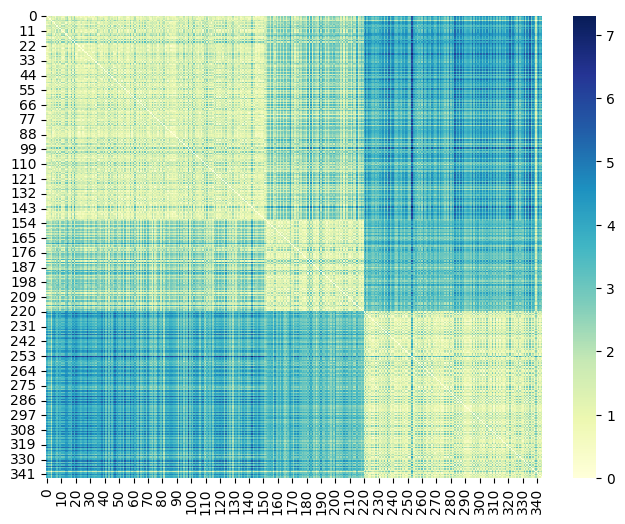

In [130]:
plt.figure(figsize=(8, 6))
df_std_distance = pd.DataFrame(distance_std, index = df_std.index, columns = df_pen.index)
sns.heatmap(df_std_distance, annot=False, cmap="YlGnBu", fmt=".1f")
plt.show()

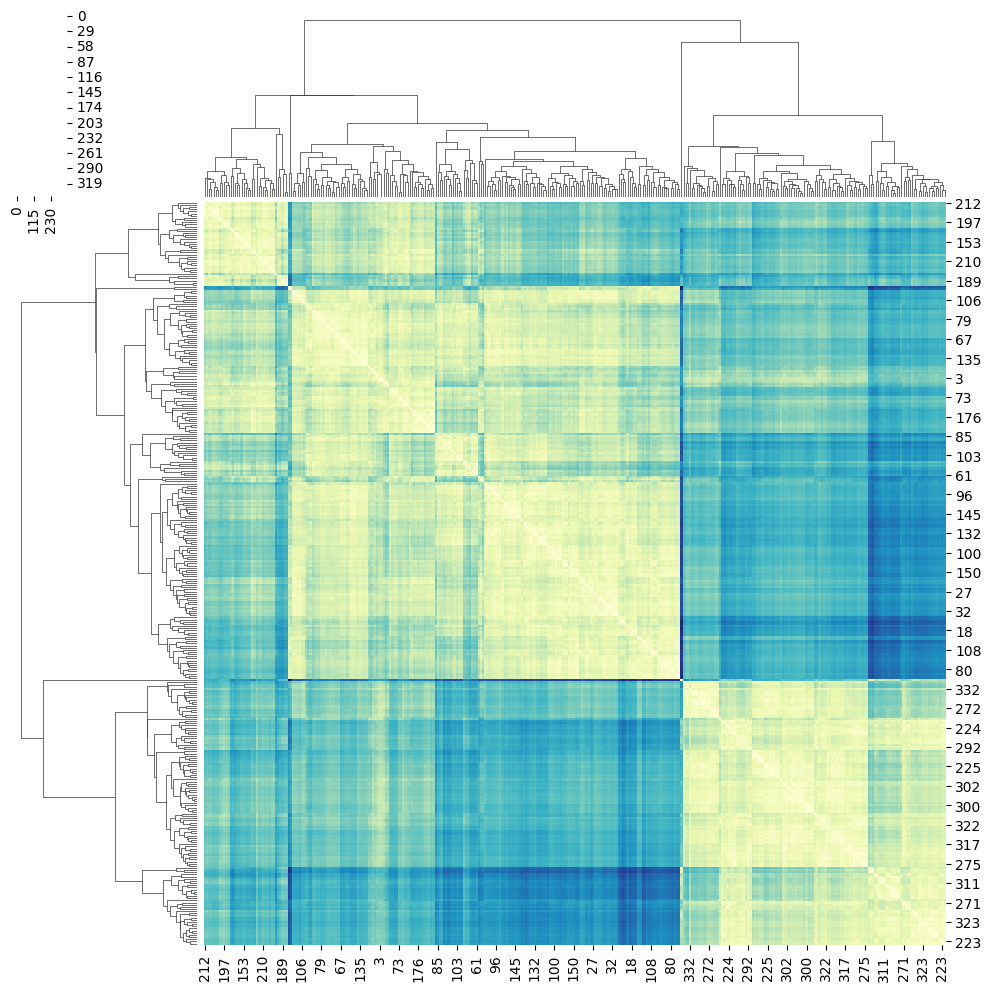

In [131]:
# Perform hierarchical clustering to get the linkage matrix
linkage = sns.clustermap(df_std_distance, cmap="YlGnBu", fmt=".1f", annot=False, method='average').dendrogram_row.linkage

# Reorder the data based on the hierarchical clustering
order = pd.DataFrame(linkage, columns=['cluster_1', 'cluster_2', 'distance', 'new_count']).index
reordered_data = df_pen.reindex(index=order, columns=order)

# Optionally, you can add color bar
sns.heatmap(reordered_data, cmap="YlGnBu", fmt=".1f", cbar=False)
plt.show()

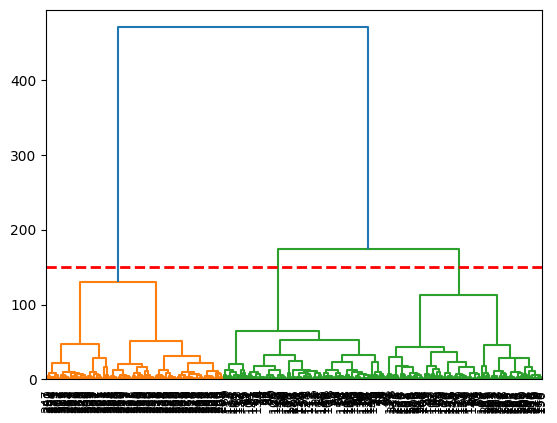

In [132]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Calculate the linkage matrix
linkage_matrix = sch.linkage(df_std_distance, method='ward')  # You can choose a different linkage method if needed

# Create the dendrogram
dendrogram = sch.dendrogram(linkage_matrix, labels=df_pen.index, leaf_font_size=9, leaf_rotation=90)
plt.axhline(y=150, color='r', linestyle='--', linewidth=2)

# Display the dendrogram
plt.show()


viendo el dendograma podemos establecer la linea de corte, en los 3 gripos marcados que vemos en la figura 
notemos como el grupo de la izquierda (color naraja) se divide a su vez en dos como el problema se trata de pinguinos muy probblemente se refiera a los generos de esta especia. Lo mismo ocurre para el caso del extremo derecho 

Sin embargo es llamativo como el grupo del medio no presenta el mismo comportamiento si no que existe un subgrupo que se une muy despues a los otros por lo que podria considerarse la linea de corte un poco antes para ver con mayor detalle a que se deben etas agrupaciones por lo que presentaremos otro dendograma con el punto de corte en y=60 , genrando 6 grupos

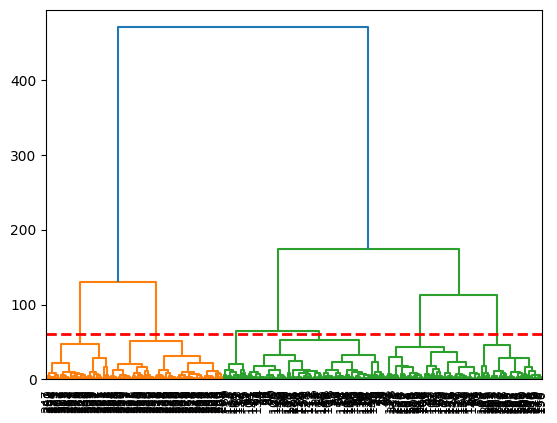

In [133]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Calculate the linkage matrix
linkage_matrix = sch.linkage(df_std_distance, method='ward')  # You can choose a different linkage method if needed

# Create the dendrogram
dendrogram = sch.dendrogram(linkage_matrix, labels=df_pen.index, leaf_font_size=9, leaf_rotation=90)
plt.axhline(y=60, color='r', linestyle='--', linewidth=2)

# Display the dendrogram
plt.show()

**ASIGNACION DE CADA OBSERVACION A LOS CLUSTERS (3 CLUSTERS)**

In [134]:
# Eligiendo el punto de corte en 3 clusters 
num_clusters = 3
cluster_assignments = sch.fcluster(linkage_matrix, num_clusters, criterion='maxclust')


In [135]:
# creacion de nuna nueva columna con la asignacion de cada registro a un cluster especifico
df_std['Cluster4'] = cluster_assignments

**REPRESENTACION DE LOS DATOSSEGUN LOS CLUSTERS FORMADOS**

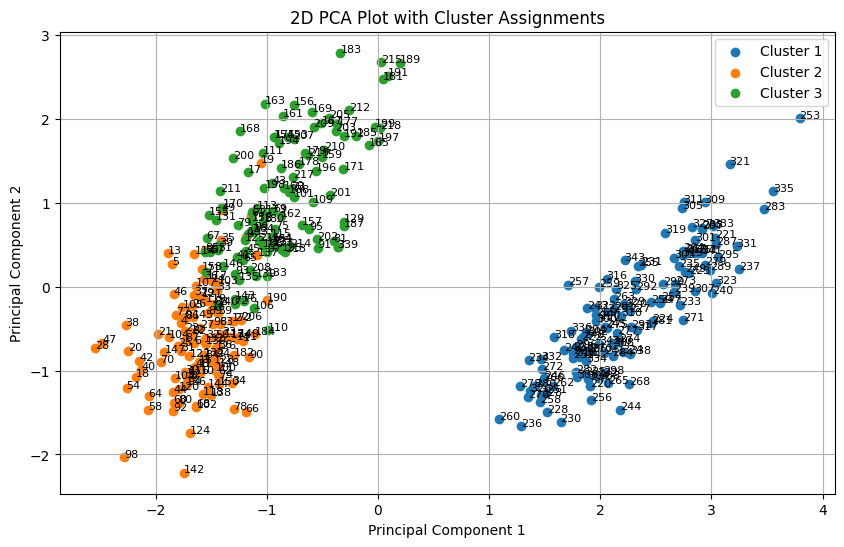

In [136]:
#Repre

# Step 1: Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_std)

# Create a new DataFrame for the 2D principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(cluster_assignments):
    plt.scatter(df_pca.loc[cluster_assignments == cluster, 'PC1'],
                df_pca.loc[cluster_assignments == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(df_std.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

**ASIGNACION DE CADA OBSERVACION A LOS CLUSTERS (6 CLUSTERS)**

In [137]:
# Eligiendo el punto de corte en 6 clusters 
num_clusters = 6
cluster_assignments = sch.fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# creacion de nuna nueva columna con la asignacion de cada registro a un cluster especifico
df_std['Cluster6'] = cluster_assignments

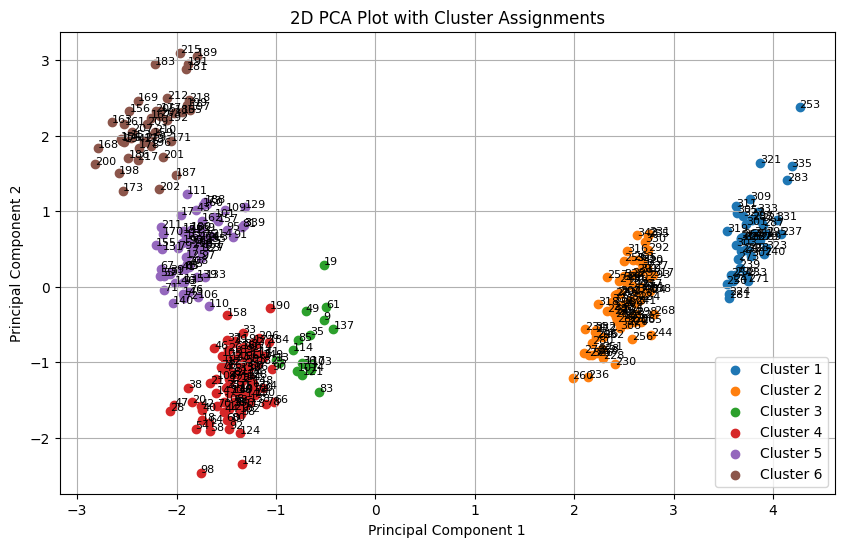

In [138]:
#Repre

# Step 1: Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_std)

# Create a new DataFrame for the 2D principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(cluster_assignments):
    plt.scatter(df_pca.loc[cluster_assignments == cluster, 'PC1'],
                df_pca.loc[cluster_assignments == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(df_std.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

despues de una comprobacion de algunos de los valores que representan estos cluster, noto que es correspondientes a los generas de cada especie 
de lo que podemos concluir que el corte en 3 clusters es reperesentativo de las especies, y el de 6 clusters es de las especies con sus generos
ademas el gupo que vimos en el agrupamiento central del dendograma que tiene un gruopo que se une muy despues es el cluster 4 y 3. como vemos un menor grupo es representado en el cluster 3

Ademas los clusters no estan separados determinanatemente por el genero, en su mayoria cumplen la regla pero pueden existir modelos atipicos dentro de cada genero que pasan a otro cluster. 

VEREMOS A CONTINUACION EL CLUSTER NO JERARQUICO 

In [139]:
from sklearn.cluster import KMeans

# escogiendo el numero de cluster del jerarquico igual a 3
k = 3

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, random_state=0)

# Fit the KMeans model to your standardized data
kmeans.fit(df_std)

# Get the cluster labels for your data
kmeans_cluster_labels = kmeans.labels_


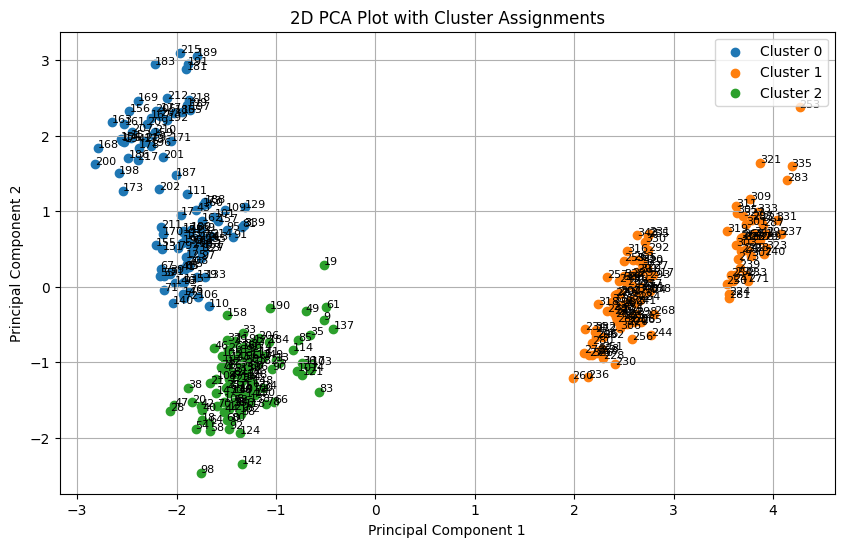

In [140]:
# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(kmeans_cluster_labels):
    plt.scatter(df_pca.loc[kmeans_cluster_labels == cluster, 'PC1'],
                df_pca.loc[kmeans_cluster_labels == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(df_std.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

Si bien vemos que el numero de cluster = 3 es apropiado vemos como hay una segmentacion muy notoria entre los cluster, esto debe darnos la idea de genero por lo que veremos el clustering no jerarquico con 6 grupos

In [141]:
# escogiendo el numero de cluster del jerarquico igual a 3
k = 6

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, random_state=0)

# Fit the KMeans model to your standardized data
kmeans.fit(df_std)

# Get the cluster labels for your data
kmeans_cluster_labels = kmeans.labels_

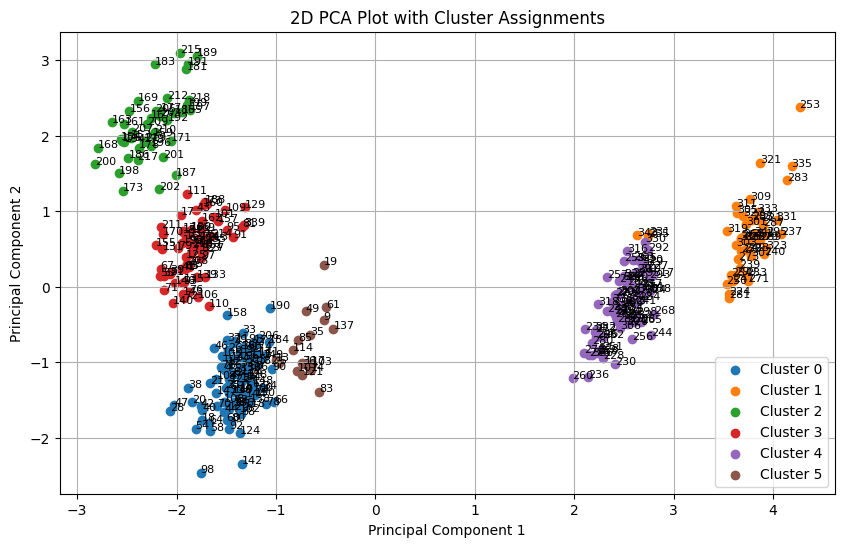

In [142]:
# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(kmeans_cluster_labels):
    plt.scatter(df_pca.loc[kmeans_cluster_labels == cluster, 'PC1'],
                df_pca.loc[kmeans_cluster_labels == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(df_std.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

Esta distribucion es logica debido a que se espera tener las especias como lo determinaba e PCA. Gento a la izquierda 
Adeline en la izquierda inferior y Chinstrap en la parte izquiera superior.

Pero con una subseparacion por genero

NOTA: de momento tenemos una idea de que cluster podemos utilizar, posteriormente veremos el metodo de la imagen para determinar que numero de cluster es mas determinante. 

**METODO DEL CODO PARA VER EL NUMERO OPTIMO DE CLUSTERS**

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#Create an array to store the WCSS values for different values of K:
wcss = []

for k in range(1, 11):  # You can choose a different range of K values
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_std)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS value

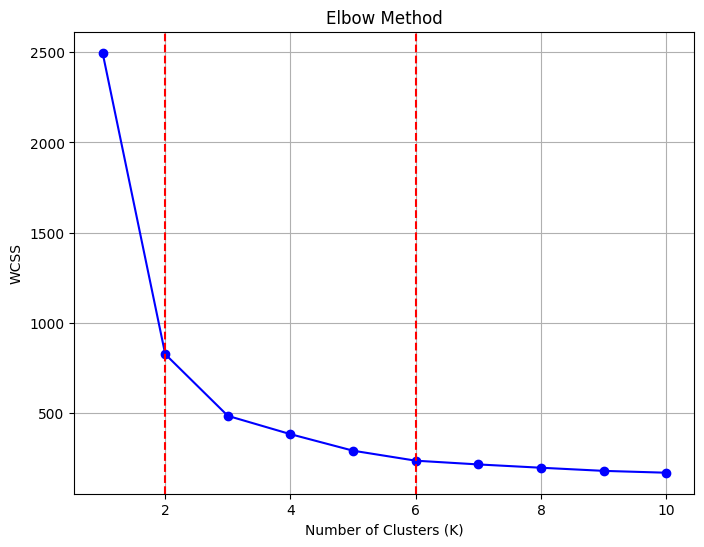

In [144]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.axvline(x=2, color='r', linestyle='--', label='3 clusters')
plt.axvline(x=6, color='r', linestyle='--', label='6 clusters')
plt.grid(True)
plt.show()


recordemos que el metodo del codo que vemos, esta basado en la metrica de performance INERCIA, la cual mide el error medio del la distancia entre los elementos y el centroide mas proximo a estos. 
Esta medida es efectiva , sin embargo engañosa debido a que si tenemos tantos clusters como numero de observaciones la enercia seria la maxima posible 

Para el grafico anterior vemos como el codo se forma (la curva se suaviza) entre 2 y 6 clusters, y recordemos que nuestro numero de clusters esta en 3 y 6 
por lo que esta medida de inercia no nos brinda una informacion determinista para obtener el numero adecuado de clusters.

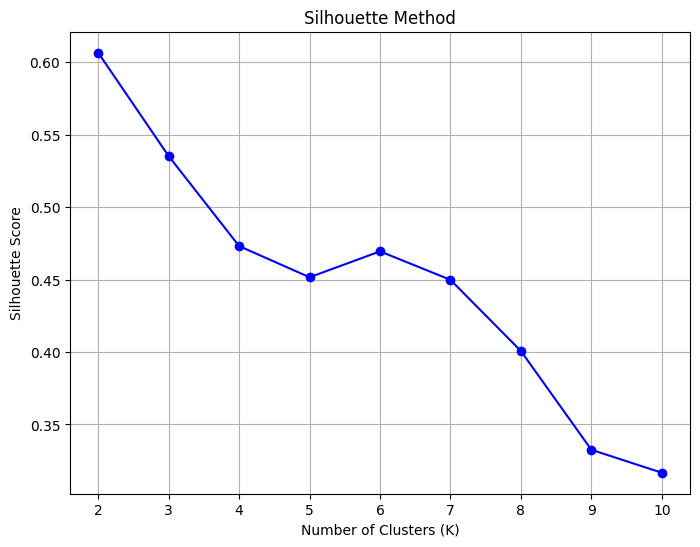

In [145]:
#silhouete score

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Create an array to store silhouette scores for different values of K

silhouette_scores = []

#Run K-means clustering for a range of K values and calculate the silhouette score for each K:

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_std)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_std, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [146]:
silhouette_scores

[0.606542857771689,
 0.5351991806957603,
 0.4731158053858735,
 0.45158265752887505,
 0.4694585221274032,
 0.4498030035058833,
 0.4006723213021356,
 0.3325148325638931,
 0.31670269297379544]

recordeos que el metodo de la silueta toma en consideracion las distancias de las observaciones al centroide mas cercano y la distancia (lejania) hacia el cluster mas proximo por lo que nos proporciona una decision mas robusta del numero de cluster 

Segun observamos en la grafica : 
- 2 clusters seria la mas optima sin embargo es una solucion muy simplista
- 3 lusters es un optimo global y efectivo, el cual nos hace refeencia al numero de especies de pinguinos 
- lo interesante llega con los cluster 4 y 6, que se postulan como clusters mas compleos detallados y aproximadamente con el mismo grado de precision. 

VEAMOS EL AGRUPAMIENTO CON 4 CLUSTERS.

In [147]:
# escogiendo el numero de cluster del jerarquico igual a 4
k = 4

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, random_state=0)

# Fit the KMeans model to your standardized data
kmeans.fit(df_std)

# Get the cluster labels for your data
kmeans_cluster_labels = kmeans.labels_

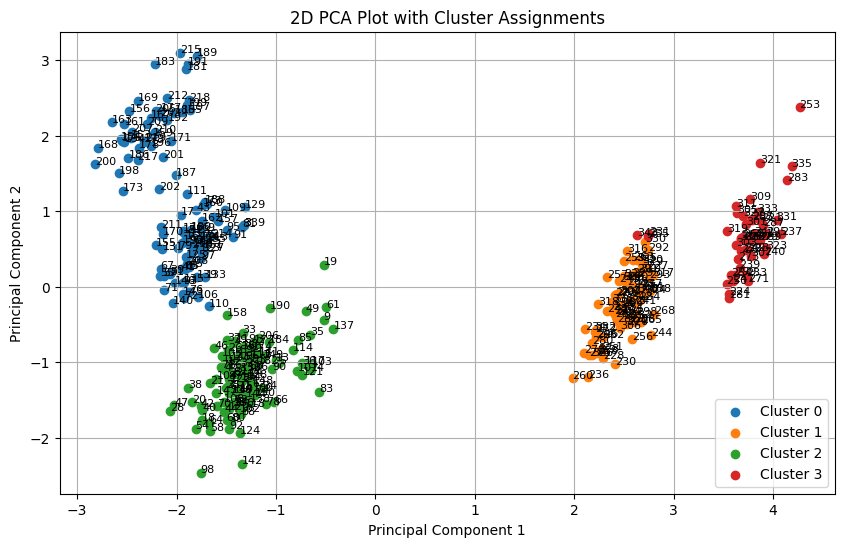

In [148]:
# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(kmeans_cluster_labels):
    plt.scatter(df_pca.loc[kmeans_cluster_labels == cluster, 'PC1'],
                df_pca.loc[kmeans_cluster_labels == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(df_std.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

En un principio vemos que con 4 clusters, la agrupacion tiene mas efectividad que la de 6 clusters
 el conocimiento previo del dataset que nos indica que son 3 especies con generos de macho y hembra, nos induce a seleccionar 6 clusters
pero esta clasificacion es muy llamativa ya que vemos como genera un cambio solamente en la separacion de los clsuters de la derecha

Nos quedaremos con 6 clusters 

**Cluste No Jerarquico**


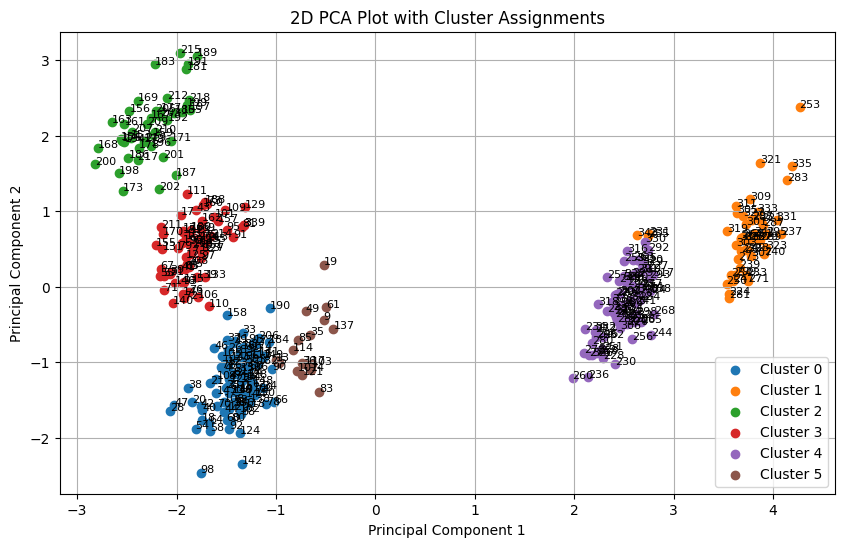



**Cluster Jerarquico**

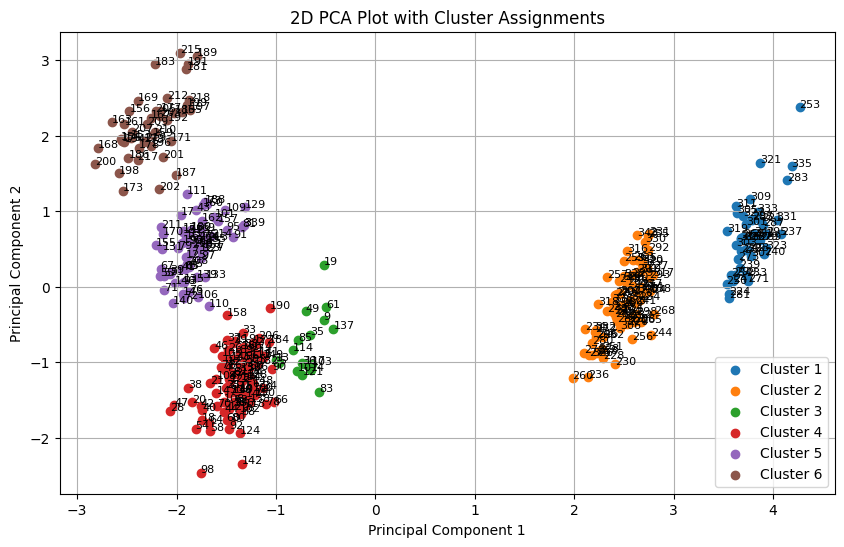



Por lo que se puede apreciar que la diferencia de las asignaciones de las categorias para el clustering jerarquico y no jerarquico es del rgistro 342 y 234. asignados al cluster mas proximo en el no jeraquico


Para la asignacion del resto de resultados no existe variacion entre el jerarquico y no jerarquico 

**INTERPRETACION DE LOS RASGOS CARACTERISTICOS DE CADA CLUSTER**

In [151]:
df_std['Cluster6'].unique()

array([4, 5, 3, 6, 2, 1])

In [150]:
df_std_sort = df_std.sort_values(by="Cluster6")

cluster_centroids = df_std_sort.groupby('Cluster6').mean()
cluster_centroids.round(2)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,Cluster4
Cluster6,,,,,
1,1.19,-0.73,1.62,1.74,1.0
2,0.37,-1.31,0.90,0.73,1.0
3,-0.84,1.71,-0.53,-0.25,2.0
4,-1.11,0.32,-1.03,-1.00,2.0
5,-0.22,0.57,-0.45,-0.26,3.0
6,1.30,0.91,-0.14,-0.41,3.0


In [154]:
df_pen['label']  = df_std['Cluster6']
cluster_centroids = df_pen.groupby('label').mean()
cluster_centroids.round(2)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
label,,,,
1,50.38,15.71,223.66,5594.32
2,45.91,14.58,213.58,4787.34
3,39.37,20.52,193.53,4000.00
4,37.88,17.78,186.52,3401.82
5,42.70,18.27,194.65,3995.51
6,51.01,18.95,199.00,3875.60


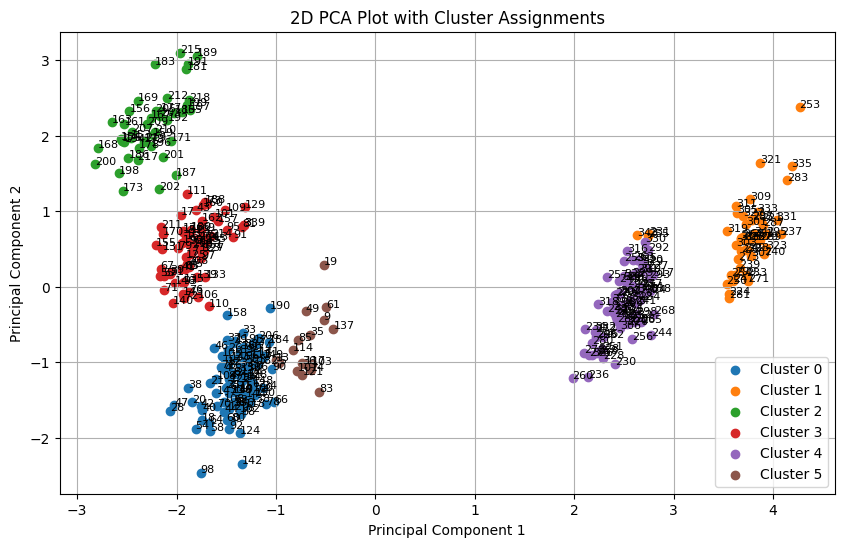

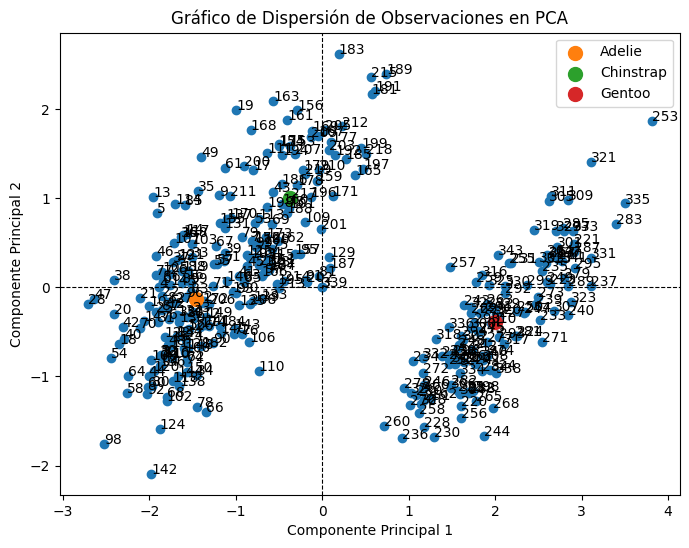

**INTERPRETACION DE LOS DATOS**



nota -- En la grafica los cluster van de 0-5 y en el dataframe de 1-6, tener cuidado cuando haga mencion a los cluster
sera segun el dataframe resumen de los datos no el grafico. 

Como vemos en los 6 clusters seleccionados, Estos son Representativos 
el cluster 3 y 4 son representativos de la specie CHINESTRAP , ademas el cluster 4 es representstivo de las hembras
como podemos ver en CHINESTRAP y posterormente en todas las especies las hembras tienen menores valores en todos los atributos fisicos de las especies correspondientes.

Los cluster 1 y 6 son representativos de ADELINE 

y los cluster 2 y 5 son representativos de GENTOO 


Adicional a estas separaciones Hablando de caractersiticas fisicas concretas entre especies podemos aclarar que : 

La especie con los rasgos fisicos mas grandes es Adeline 
y la que posee los menores es CHINESTRAP


**Limitaciones**


Seria bueno probar mas metodos de calculo de distancia en el cluster jerarquico y realizar comparativas de como se ven los clusters 


Ademas viendo algunos resultados, por mas que los clsuters nos dan una idea de que genero existe en cada grupo. Existen algunos elementos de cada especie Femininos que estan en el cluster de machos de esta especie.
Lo cual nos da la idea que existen valores atipicos dentro de clusters incluso 
Esto podria hacerse con un cluster supervisado, realizando una etiqueta a esos registros "atipicos" 


En un principio pense que seria buena idea realizar DBSCAN, ya que se visualiza ese salto entre especie y especie y por genero 
